In [16]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from skimage import io

In [18]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

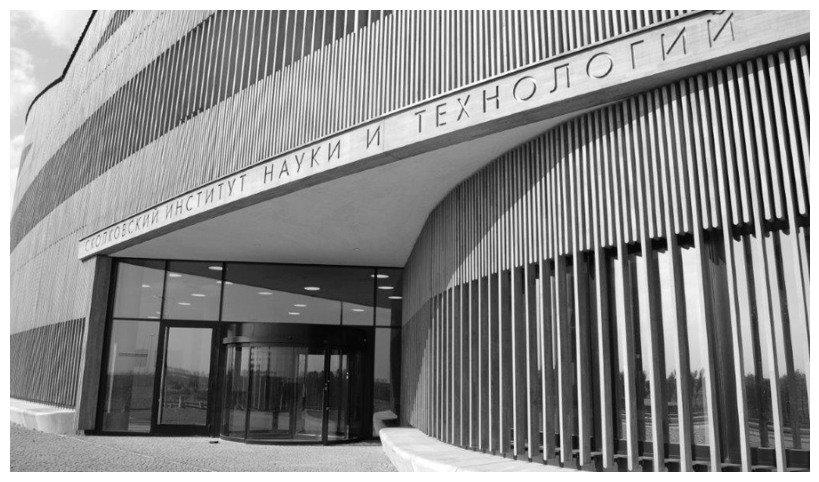

In [19]:
img_orig = np.int16(io.imread('skoltech_0.jpg'))
img = np.float32(cv2.imread('skoltech_0.jpg', 0))

plot_img(img)

## Noise reduction via GK

In [20]:
import scipy.stats as st


def get_gk(size=17, nsig=3):
    """Returns a 2D Gaussian kernel"""

    x = np.linspace(-nsig, nsig, size + 1)
    kernel_1d = np.diff(st.norm.cdf(x))
    
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    kernel_2d_norm = kernel_2d / kernel_2d.sum()
    
    return kernel_2d_norm

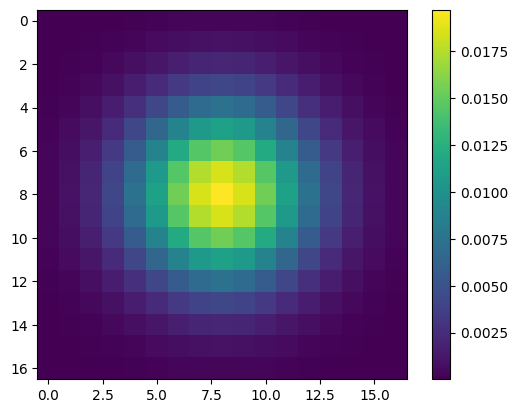

In [21]:
plt.imshow(get_gk())
# plt.axis('off')
plt.colorbar()
plt.show()

In [22]:
from scipy.ndimage import convolve

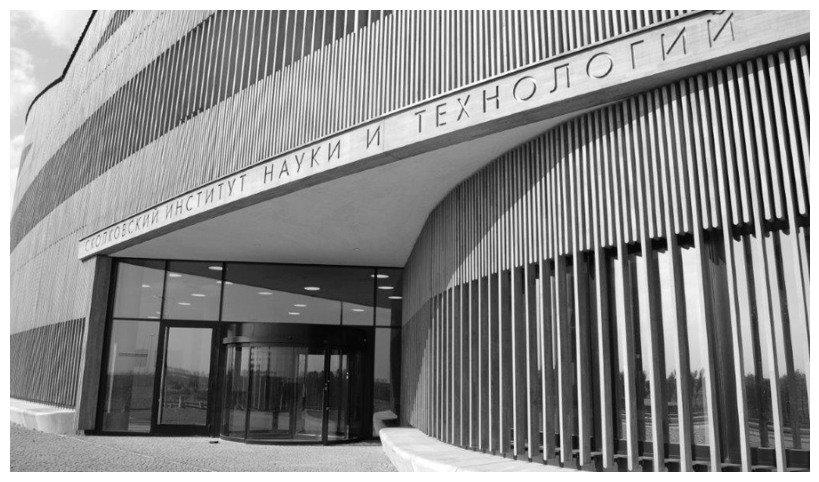

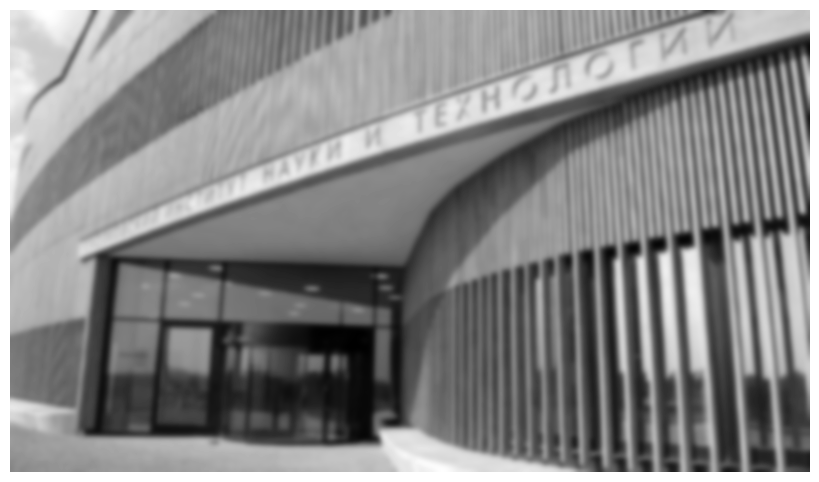

In [23]:
img_smoothed = convolve(np.float32(img), get_gk())

plot_img(img)
plot_img(img_smoothed)

## Gradient calculation via Sobel filters

In [24]:
def sobel_filters(img):
    """Applies Sobel filters to obtain gradient values and directions"""
    
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype='float32')
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype='float32')
    
    grad_x = convolve(img, kernel_x)  # approximate derivative on x
    grad_y = convolve(img, kernel_y)  # approximate derivative on y
    
    # Gradient values
    grad = np.hypot(grad_x, grad_y)  # sqrt(grad_x ** 2 + grad_y ** 2)
    grad = grad / grad.max() * 255
    # Gradient directions
    theta = np.arctan2(grad_y, grad_x)
    
    return np.float32(grad), np.float32(theta)

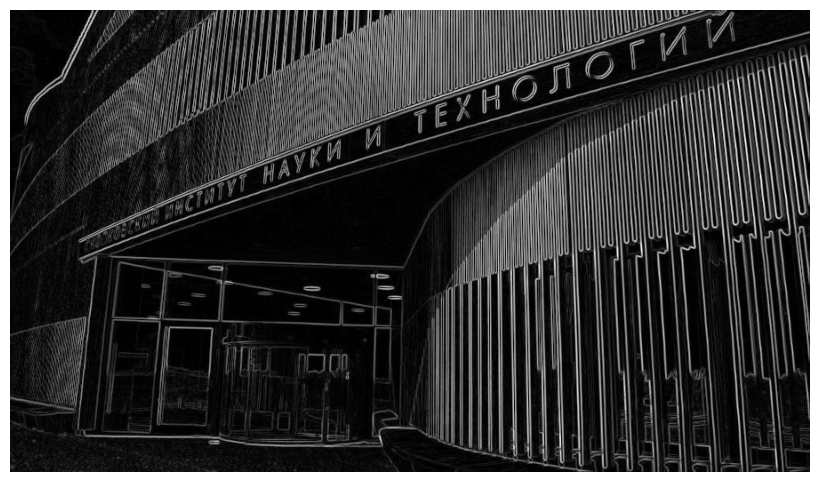

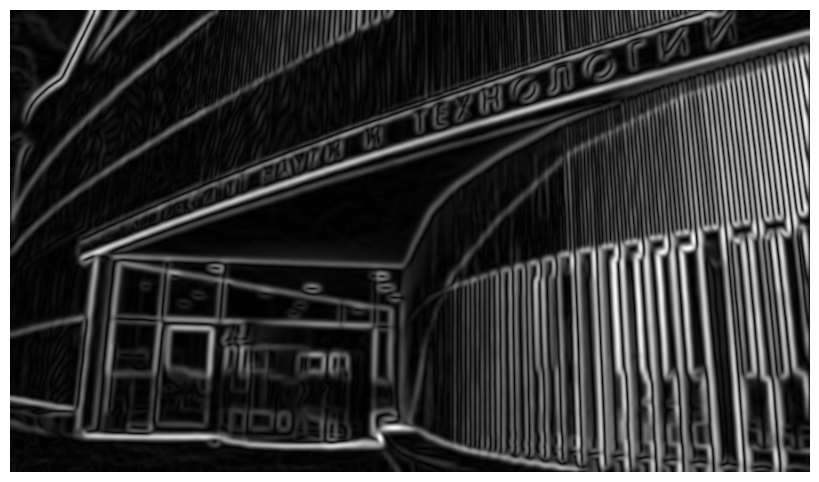

In [25]:
grad1, theta1 = sobel_filters(img)
grad, theta = sobel_filters(img_smoothed)

plot_img(grad1)
plot_img(grad)

## Non-maximum suppression

In [26]:
def non_max_suppression(grad, theta):
    grad_processed = np.zeros_like(grad, dtype='float32')
    angle = theta * 180. / np.pi  # cast it into degrees:)
    angle[angle < 0] += 180

    # python loop, kek
    # TODO: how can we vectorize that?
    for i in range(1, grad_processed.shape[0] - 1):
        for j in range(1, grad_processed.shape[1] - 1):
            q = 255
            r = 255
            
            try:
                # angle 0
                if (0 <= angle[i, j] < np.pi/8) or (np.pi*7/8 <= angle[i, j] <= np.pi):
                    q = grad[i, j+1]
                    r = grad[i, j-1]
                # angle 45
                elif (np.pi/8 <= angle[i, j] < np.pi*3/8):
                    q = grad[i+1, j-1]
                    r = grad[i-1, j+1]
                # angle 90
                elif (np.pi*3/8 <= angle[i, j] < np.pi*5/8):
                    q = grad[i+1, j]
                    r = grad[i-1, j]
                # angle 135
                elif (np.pi*5/8 <= angle[i, j] < np.pi*7/8):
                    q = grad[i-1, j-1]
                    r = grad[i+1, j+1]

                if (grad[i, j] >= q) and (grad[i, j] >= r):
                    grad_processed[i, j] = grad[i, j]
                else:
                    grad_processed[i, j] = 0

            except IndexError:
                pass
    
    return grad_processed

In [13]:
grad_processed = non_max_suppression(grad, theta)

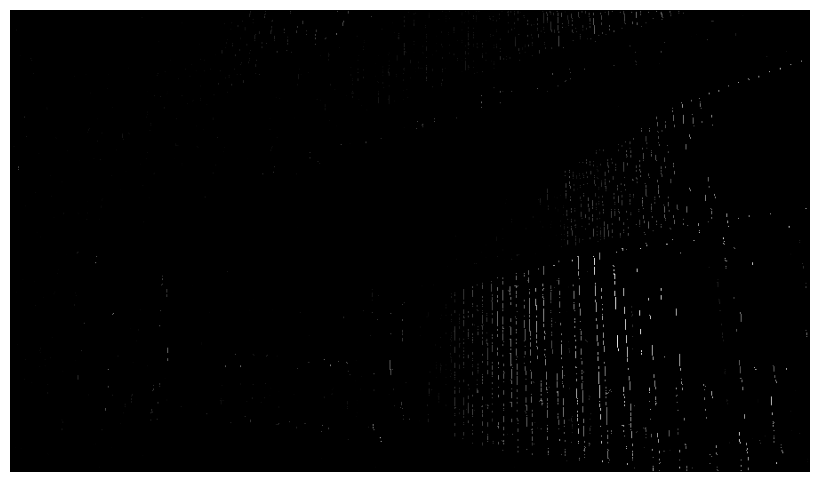

In [14]:
plot_img(grad_processed)

## Hysteresis Thresholding

In [15]:
from skimage.measure import label


def thresholding(img, min_val=100, max_val=200):
    res = np.zeros_like(img, dtype='int16')
    
    strong_i, strong_j = np.where(img >= max_val)
    weak_i, weak_j = np.where((img <= max_val) & (img >= min_val))
    
    res[strong_i, strong_j] = 255
    res[weak_i, weak_j] = 128
                            
    lbl, n_lbl = label(res > 0, connectivity=2, return_num=True)
    for n in range(1, n_lbl + 1):
        lbl_mask = lbl == n
        if 255 not in res[lbl_mask]:
            res[lbl_mask] = 0
        else:
            res[lbl_mask] = 255
    
    return res

In [15]:
grad_canny = thresholding(grad_processed, 10, 100)

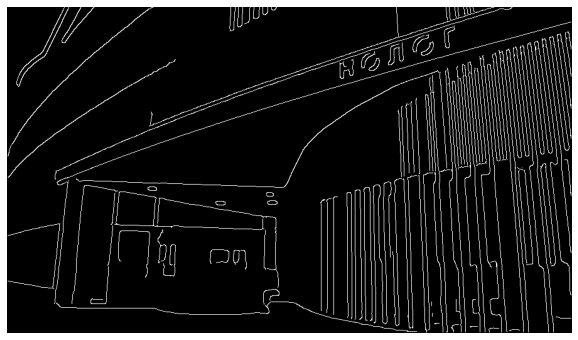

In [16]:
plot_img(grad_canny)

In [17]:
def canny_edge_detector(img_gray, smooth_kernel_size=17, min_val=30, max_val=100):
    img_smoothed = convolve(img_gray, get_gk(size=smooth_kernel_size))
    grad, theta = sobel_filters(img_smoothed)
    edges = non_max_suppression(grad=grad, theta=theta)
    edges_th = thresholding(edges, min_val=min_val, max_val=max_val)
    return edges_th

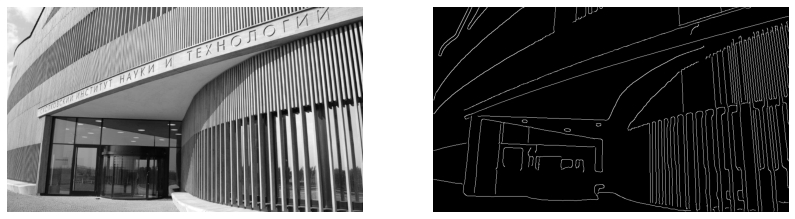

In [18]:
edges = canny_edge_detector(img, 21, 20, 90)

plt.figure(figsize=(14,8))

plt.subplot('121')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot('122')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.show()

## Canny pipeline playground

In [19]:
from ipywidgets import IntSlider, interact

In [20]:
sld1 = IntSlider(value=17, min=0, max=50, step=1, continuous_update=False)
sld2 = IntSlider(value=10, min=1, max=254, step=1, continuous_update=False)
sld3 = IntSlider(value=100, min=1, max=254, step=1, continuous_update=False)


def vary_canny_parameters(kernel_size, minVal, maxVal, use_cv2=False):
    if use_cv2:
        img_smoothed = convolve(img, get_gk(size=kernel_size))
        plot_img(cv2.Canny(np.uint8(img_smoothed), minVal, maxVal))
    else:
        plot_img(canny_edge_detector(img, kernel_size, minVal, maxVal))

In [21]:
interact(vary_canny_parameters, kernel_size=sld1, minVal=sld2, maxVal=sld3, use_cv2=True);

interactive(children=(IntSlider(value=17, continuous_update=False, description='kernel_size', max=50), IntSlid…